<a href="https://colab.research.google.com/github/daichira-gif/daichira/blob/main/Google_Gemini_%E3%82%AB%E3%83%A1%E3%83%A9%E7%94%BB%E5%83%8F%E3%81%AE%E8%AA%AC%E6%98%8E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- カメラを起動、撮影
- 画像の読み込み
- 画像に関する質問に回答

（参照）<br>
https://note.com/astropomeai/n/n6f6ba461d36f <br>
https://blog.kikagaku.co.jp/pillow/


In [1]:
# パッケージのインストール
!pip install -q -U google-generativeai
!pip install pydub
!pip install Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.9/146.9 kB 3.0 MB/s eta 0:00:00


In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [6]:
from google.colab import userdata

# Or use `os.getenv('GOOGLE_API_KEY')` to fetch an environment variable.
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)

In [7]:
#カメラの起動と写真撮影
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Saved to photo.jpg


In [8]:
import cv2
import os
from collections import deque
from datetime import datetime
from pydub import AudioSegment
from pydub.playback import play
import google.generativeai as genai
import PIL.Image
import numpy as np

def wrap_text(text, line_length):
    """テキストを指定された長さで改行する"""
    words = text.split(' ')
    lines = []
    current_line = ''

    for word in words:
        if len(current_line) + len(word) + 1 > line_length:
            lines.append(current_line)
            current_line = word
        else:
            current_line += ' ' + word

    lines.append(current_line)  # 最後の行を追加
    return lines

def add_text_to_frame(frame, text):
    # テキストを70文字ごとに改行
    wrapped_text = wrap_text(text, 70)

    # フレームの高さと幅を取得
    height, width = frame.shape[:2]

    # テキストのフォントとサイズ
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.0  # フォントサイズを大きくする
    color = (255, 255, 255)  # 白色
    outline_color = (0, 0, 0)  # 輪郭の色（黒）
    thickness = 2
    outline_thickness = 4  # 輪郭の太さ
    line_type = cv2.LINE_AA

    # 各行のテキストを画像に追加
    for i, line in enumerate(wrapped_text):
        position = (10, 30 + i * 30)  # 各行の位置を調整（より大きい間隔）

        # テキストの輪郭を描画
        cv2.putText(frame, line, position, font, font_scale, outline_color, outline_thickness, line_type)

        # テキストを描画
        cv2.putText(frame, line, position, font, font_scale, color, thickness, line_type)

def save_frame(frame, filename, directory='./frames'):
    # ディレクトリが存在しない場合は作成
    if not os.path.exists(directory):
        os.makedirs(directory)
    # ファイル名のパスを作成
    filepath = os.path.join(directory, filename)
    # フレームを保存
    cv2.imwrite(filepath, frame)

def save_temp_frame(frame, filename, directory='./temp'):
    # ディレクトリが存在しない場合は作成
    if not os.path.exists(directory):
        os.makedirs(directory)
    # ファイル名のパスを作成
    filepath = os.path.join(directory, filename)
    # フレームを保存
    cv2.imwrite(filepath, frame)
    return filepath  # 保存したファイルのパスを返す

def send_frame_with_text_to_gemini(frame, previous_texts, timestamp, user_input, client):

    temp_file_path = save_temp_frame(frame, "temp.jpg")
    img = PIL.Image.open(temp_file_path)

    img = np.array(img)


    # 過去のテキストをコンテキストとして結合
    context = ' '.join(previous_texts)

    # Geminiモデルの初期化
    model = client.GenerativeModel('gemini-pro-vision')

    # モデルに画像とテキストの指示を送信
    prompt = f"Given the context: {context} and the current time: {timestamp}, please respond to the following message in Japanese without repeating the context. Message: {user_input}"
    img = Image.fromarray(frame)
    response = model.generate_content([prompt, img], stream=True)
    response.resolve()

    # 生成されたテキストを返す
    return response.text



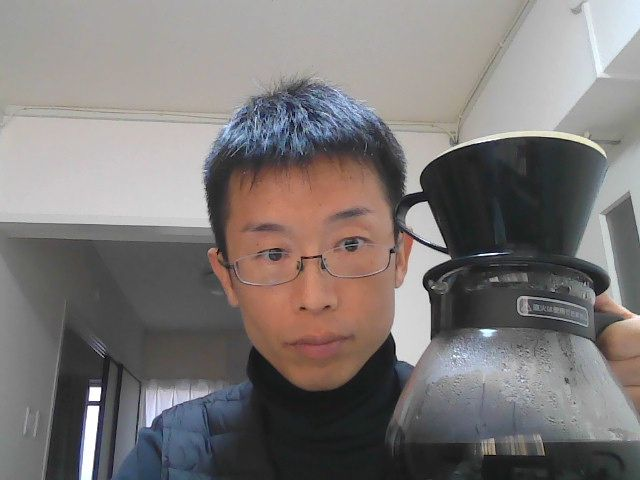

In [9]:

#　モジュールの読み込み
from PIL import Image

#　画像の読み込み
img2 = Image.open('photo.jpg')

img2

In [12]:

def main():
    genai.configure(api_key=GOOGLE_API_KEY)
    filename = 'photo.jpg'

    try:
         video = Image.open('photo.jpg')

    except IOError as e:
        print(f"エラーが発生しました: {e}")
        return

    # 最近の5フレームのテキストを保持するためのキュー
    previous_texts = deque(maxlen=5)

    while True:

        print("新しいプロンプトを入力するか、Enterキーを押して続行してください (プログラムを終了するには 'exit' と入力）:")
        user_input = input().strip()  # 入力を受け取る

        if user_input == "exit":
            print("了解しました。")
            break

        if not user_input:
            user_input = "Tell me what you see."

        frame = video
        frame = np.array(frame)

        # 現在のタイムスタンプを取得
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        # geminiにフレームを送信し、生成されたテキストを取得
        generated_text = send_frame_with_text_to_gemini(frame, previous_texts, timestamp, user_input, genai)
        print(f"Timestamp: {timestamp}, Generated Text: {generated_text}")

        # タイムスタンプ付きのテキストをキューに追加
        previous_texts.append(f"[{timestamp}] Message: {user_input}, Generated Text: {generated_text}")

        # フレームにテキストを追加(日本語は文字化けします)
        text_to_add = f"{timestamp}: {generated_text}"

        add_text_to_frame(frame, text_to_add)

        # フレームを保存
        filename = f"{timestamp}.jpg"
        save_frame(frame, filename)

    # ビデオをリリースする
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


新しいプロンプトを入力するか、Enterキーを押して続行してください (プログラムを終了するには 'exit' と入力）:
exit
了解しました。
